In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

# Basic Time Series Model

## Oil Price Data Processing

In [2]:
oil_price = pd.read_csv('Oil_Price.csv')
oil_price.head()

,DATE,DCOILWTICO
0,2020-04-21,8.91
1,2020-04-22,13.64
2,2020-04-23,15.06
3,2020-04-24,15.99
4,2020-04-27,12.17


In [3]:
oil_price.shape

(561, 2)

In [4]:
# Convert string to Datetime
oil_price['DATE'] = pd.to_datetime(oil_price['DATE'])

In [5]:
# Process the oil price data, there are some '.' data in it
oil_price.loc[oil_price['DCOILWTICO'] == '.','DCOILWTICO'] = np.nan

# Fill the None with the last day's price
oil_price = oil_price.fillna(method='pad')

In [6]:
# Set time as index
oil_price_with_date_index = oil_price.set_index('DATE')
oil_price_with_date_index

,DCOILWTICO
DATE,
2020-04-21,8.91
2020-04-22,13.64
2020-04-23,15.06
2020-04-24,15.99
2020-04-27,12.17
...,...
2022-06-08,121.94
2022-06-09,121.52
2022-06-10,120.73


<AxesSubplot:xlabel='DATE'>

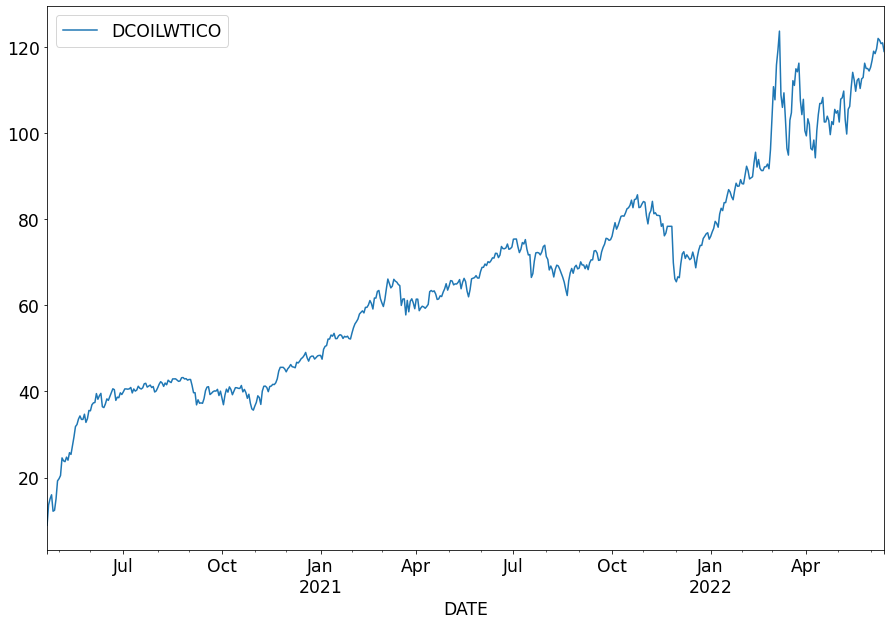

In [7]:
# Convert the price data type to 'float'
oil_price_with_date_index['DCOILWTICO'] = oil_price_with_date_index['DCOILWTICO'].astype(float)
oil_price_with_date_index.plot()

In [8]:
# Add one column named 'Julian'
oil_price_with_date_index['Julian'] = oil_price_with_date_index.index.to_julian_date()
oil_price_with_date_index

,DCOILWTICO,Julian
DATE,,
2020-04-21,8.91,2458960.5
2020-04-22,13.64,2458961.5
2020-04-23,15.06,2458962.5
2020-04-24,15.99,2458963.5
2020-04-27,12.17,2458966.5
...,...,...
2022-06-08,121.94,2459738.5
2022-06-09,121.52,2459739.5
2022-06-10,120.73,2459740.5


## Support vector regression (SVR) model

C:\Anaconda\envs\news-crawler\lib\site-packages\scikit_learn-1.1.1-py3.9-win-amd64.egg\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\envs\news-crawler\lib\site-packages\scikit_learn-1.1.1-py3.9-win-amd64.egg\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


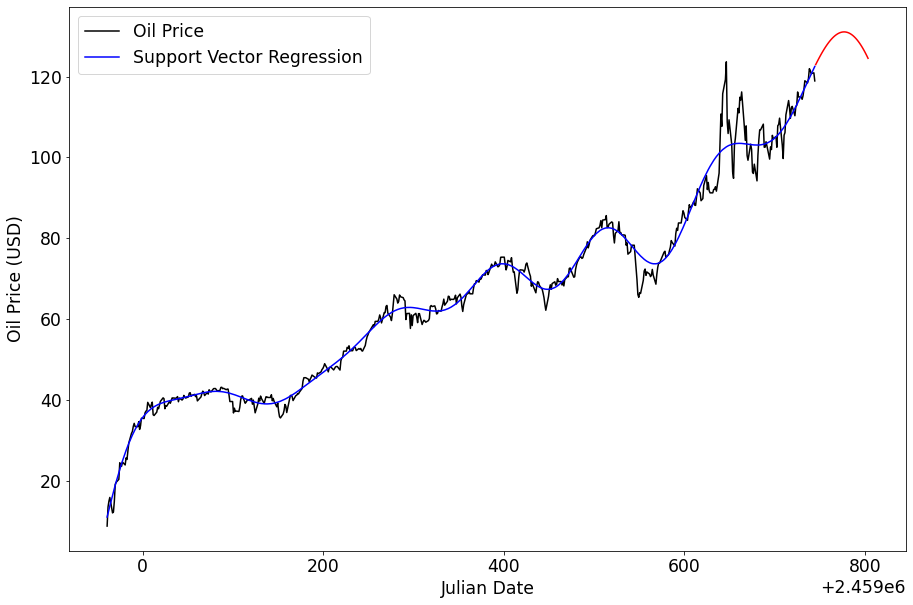

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt

future_days = []


days = oil_price_with_date_index["Julian"].to_frame()
price = oil_price_with_date_index['DCOILWTICO'].to_frame()

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.0001).fit(days, price)


# Extend a number of days for forecasting the future 
last_day = 2459744.5
for i in range(1, 60):
    future_days.append([last_day + i])


svr_rbf_pred = list(map(lambda x: float(x), svr_rbf.predict(days)))
svr_rbf_pred_future = list(map(lambda x: float(x), svr_rbf.predict(future_days)))

plt.plot(days, price, color='black', label='Oil Price')
plt.plot(days, svr_rbf_pred, color='blue', label='Support Vector Regression')
plt.plot(future_days, svr_rbf_pred_future, color='red')
plt.xlabel('Julian Date')
plt.ylabel('Oil Price (USD)')
plt.legend(loc=2)
plt.show()

# LSTM Model

In [10]:
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Input, LSTM, Dense
import h5py


In [11]:
# length of data
length = 561

# Fetch around 80% as training data
length *= 0.8
print(length)

batch_size = 30
train_length = []
for x in range(int(length)-31, int(length)):
    if (x % batch_size == 0):
        train_length.append(x)

train_data_length = max(train_length)
train_data_length

448.8


420

In [12]:
timestep = 10 # first 10 day's data to forcast next 10 days
timestep_added_length = train_data_length + timestep*2
train_df = oil_price[0: timestep_added_length]
train_set_values = train_df['DCOILWTICO'].values
train_set_values = train_set_values.reshape(440, 1)
train_set_values.shape

(440, 1)

In [13]:
# Scaling each value to 0 and 1
mms = MinMaxScaler(feature_range = (0, 1))
training_set_mms = mms.fit_transform(np.float64(train_set_values))

In [14]:
X_list = []
y_list = []

for i in range(timestep, train_data_length + timestep):
    X_list.append(training_set_mms[i-timestep:i, 0])
    y_list.append(training_set_mms[i:i+timestep, 0])


In [15]:
print(len(X_list))
print(len(y_list))

420
420


In [16]:
X_train = np.array(X_list)
X_train = np.reshape(X_train, (420, 10, 1))
print(X_train.shape)

y_train = np.array(y_list)
y_train = np.reshape(y_train, (420, 10, 1))
print(y_train.shape)

(420, 10, 1)
(420, 10, 1)


In [17]:
# Construct the neural network
input_layer = Input(batch_shape=(batch_size, timestep, 1))
lstm_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_layer)
lstm_layer_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_layer_1)
output_layer = Dense(units=1)(lstm_layer_2)

rgn = Model(inputs=input_layer, outputs=output_layer)
rgn.compile(optimizer='adam', loss='mae')


In [18]:
from tqdm import tqdm

epoches = 200
for i in tqdm(range(epoches)):
    rgn.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    rgn.reset_states()

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

14/14 [==============================] - 2s 3ms/step - loss: 0.6418


  0%|▍                                                                                 | 1/200 [00:01<05:35,  1.68s/it]

14/14 [==============================] - 0s 3ms/step - loss: 0.0968


  2%|█▏                                                                                | 3/200 [00:01<01:36,  2.05it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.1365


  2%|██                                                                                | 5/200 [00:01<00:52,  3.68it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0973


  4%|██▊                                                                               | 7/200 [00:02<00:35,  5.40it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0868


  4%|███▋                                                                              | 9/200 [00:02<00:26,  7.08it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0775


  6%|████▍                                                                            | 11/200 [00:02<00:21,  8.65it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0697


  6%|█████▎                                                                           | 13/200 [00:02<00:18,  9.96it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0669


  8%|██████                                                                           | 15/200 [00:02<00:16, 11.12it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0676


  8%|██████▉                                                                          | 17/200 [00:02<00:15, 12.11it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0677


 10%|███████▋                                                                         | 19/200 [00:02<00:14, 12.87it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0675


 10%|████████▌                                                                        | 21/200 [00:03<00:13, 13.35it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0662


 12%|█████████▎                                                                       | 23/200 [00:03<00:12, 13.74it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0647


 12%|██████████▏                                                                      | 25/200 [00:03<00:12, 14.11it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0633


 14%|██████████▉                                                                      | 27/200 [00:03<00:12, 14.29it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0621


 14%|███████████▋                                                                     | 29/200 [00:03<00:11, 14.51it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0609


 16%|████████████▌                                                                    | 31/200 [00:03<00:11, 14.29it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0599


 16%|█████████████▎                                                                   | 33/200 [00:03<00:11, 14.41it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0588


 18%|██████████████▏                                                                  | 35/200 [00:03<00:11, 14.53it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0581


 18%|██████████████▉                                                                  | 37/200 [00:04<00:11, 14.61it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0573


 20%|███████████████▊                                                                 | 39/200 [00:04<00:10, 14.67it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0566


 20%|████████████████▌                                                                | 41/200 [00:04<00:10, 14.65it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0559


 22%|█████████████████▍                                                               | 43/200 [00:04<00:10, 14.66it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0553


 22%|██████████████████▏                                                              | 45/200 [00:04<00:10, 14.64it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0549


 24%|███████████████████                                                              | 47/200 [00:04<00:10, 14.69it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0546


 24%|███████████████████▊                                                             | 49/200 [00:04<00:10, 14.83it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0542


 26%|████████████████████▋                                                            | 51/200 [00:05<00:10, 14.78it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0538


 26%|█████████████████████▍                                                           | 53/200 [00:05<00:09, 14.96it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0533


 28%|██████████████████████▎                                                          | 55/200 [00:05<00:09, 15.08it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0529


 28%|███████████████████████                                                          | 57/200 [00:05<00:09, 15.10it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0523


 30%|███████████████████████▉                                                         | 59/200 [00:05<00:09, 15.11it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0515


 30%|████████████████████████▋                                                        | 61/200 [00:05<00:09, 15.06it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0510


 32%|█████████████████████████▌                                                       | 63/200 [00:05<00:09, 15.15it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0502


 32%|██████████████████████████▎                                                      | 65/200 [00:06<00:08, 15.12it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0498


 34%|███████████████████████████▏                                                     | 67/200 [00:06<00:08, 15.06it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0489


 34%|███████████████████████████▉                                                     | 69/200 [00:06<00:08, 15.12it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0485


 36%|████████████████████████████▊                                                    | 71/200 [00:06<00:08, 14.93it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0479


 36%|█████████████████████████████▌                                                   | 73/200 [00:06<00:08, 14.96it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0473


 38%|██████████████████████████████▍                                                  | 75/200 [00:06<00:08, 14.88it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0468


 38%|███████████████████████████████▏                                                 | 77/200 [00:06<00:08, 14.99it/s]

14/14 [==============================] - 0s 4ms/step - loss: 0.0462


 40%|███████████████████████████████▉                                                 | 79/200 [00:06<00:08, 14.39it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0456


 40%|████████████████████████████████▊                                                | 81/200 [00:07<00:08, 14.39it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0450


 42%|█████████████████████████████████▌                                               | 83/200 [00:07<00:08, 14.33it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0445


 42%|██████████████████████████████████▍                                              | 85/200 [00:07<00:07, 14.42it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0440


 44%|███████████████████████████████████▏                                             | 87/200 [00:07<00:07, 14.64it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0433


 44%|████████████████████████████████████                                             | 89/200 [00:07<00:07, 14.66it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0432


 46%|████████████████████████████████████▊                                            | 91/200 [00:07<00:07, 14.87it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0426


 46%|█████████████████████████████████████▋                                           | 93/200 [00:07<00:07, 14.95it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0429


 48%|██████████████████████████████████████▍                                          | 95/200 [00:08<00:06, 15.04it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0417


 48%|███████████████████████████████████████▎                                         | 97/200 [00:08<00:06, 15.01it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0438


 50%|████████████████████████████████████████                                         | 99/200 [00:08<00:06, 14.95it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0413


 50%|████████████████████████████████████████▍                                       | 101/200 [00:08<00:06, 15.08it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0568


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:08<00:06, 14.96it/s]

14/14 [==============================] - 0s 4ms/step - loss: 0.0640


 52%|██████████████████████████████████████████                                      | 105/200 [00:08<00:06, 14.01it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0729


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:08<00:06, 13.57it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0414


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:09<00:06, 13.38it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0440


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:09<00:06, 13.45it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0406


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:09<00:06, 13.86it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0545


 57%|██████████████████████████████████████████████                                  | 115/200 [00:09<00:05, 14.19it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0529


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:09<00:05, 14.47it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0554


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:09<00:05, 14.35it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0465


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:09<00:05, 14.33it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0406


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:10<00:05, 14.26it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0452


 62%|██████████████████████████████████████████████████                              | 125/200 [00:10<00:05, 14.42it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0404


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:10<00:04, 14.63it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0492


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:10<00:04, 14.56it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0453


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:10<00:04, 14.70it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0547


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:10<00:04, 14.90it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0410


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:10<00:04, 15.07it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0427


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:10<00:04, 15.03it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0408


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:11<00:04, 15.19it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0440


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:11<00:03, 15.25it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0426


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:11<00:03, 15.29it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0381


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:11<00:03, 15.28it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0425


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:11<00:03, 15.20it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0404


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:11<00:03, 15.22it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0469


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:11<00:03, 15.27it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0448


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:11<00:03, 15.34it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0499


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:12<00:02, 15.35it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0412


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:12<00:02, 15.22it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0377


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:12<00:02, 15.31it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0423


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:12<00:02, 15.34it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0403


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:12<00:02, 15.36it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0475


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:12<00:02, 15.36it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0407


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:12<00:02, 15.23it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:13<00:02, 15.28it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0418


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:13<00:01, 15.28it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0388


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:13<00:01, 15.31it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0448


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [00:13<00:01, 15.30it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0419


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [00:13<00:01, 15.25it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0424


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [00:13<00:01, 15.29it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0456


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:13<00:01, 15.36it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0415


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [00:13<00:01, 15.26it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0436


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [00:14<00:00, 15.19it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0409


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [00:14<00:00, 15.07it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0408


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:14<00:00, 15.16it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0431


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:14<00:00, 15.06it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0391


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:14<00:00, 14.87it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0402


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [00:14<00:00, 14.95it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0418


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:14<00:00, 14.88it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0398


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:15<00:00, 14.99it/s]

14/14 [==============================] - 0s 3ms/step - loss: 0.0421


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 13.25it/s]


In [19]:
# Construct the test dataset

test_length = []
for x in range(561-100, 561 - timestep*2):
    remainder = (x-timestep_added_length) % batch_size
    if (remainder == 0):
        test_length.append(x)

test_data_length = max(test_length)
test_data_length

530

In [20]:
timestep_added_length_test = test_data_length + timestep*2
test_dataset_length = test_data_length - timestep_added_length
print(timestep_added_length_test, test_dataset_length)

550 90


In [21]:
test_df = oil_price[timestep_added_length: timestep_added_length_test]
test_dataset_v = test_df['DCOILWTICO'].values
test_dataset_v = test_dataset_v.reshape(110, 1)
test_dataset_v.shape

(110, 1)

In [22]:
test_set_mms = mms.fit_transform(np.float64(test_dataset_v))

In [23]:
X_test = []
for i in range(timestep, test_dataset_length + timestep):
    X_test.append(test_set_mms[i-timestep:i, 0])
X_test = np.array(X_test)
X_test.shape

(90, 10)

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(90, 10, 1)

In [25]:
# Prediction
y_predict_ini = rgn.predict(X_test, batch_size=batch_size)
y_predict_ini.shape

3/3 [==============================] - 0s 2ms/step


(90, 10, 1)

In [26]:
y_predict_ini = np.reshape(y_predict_ini,(y_predict_ini.shape[0], y_predict_ini.shape[1]))
y_predict_ini.shape

(90, 10)

In [27]:
y_predict_ini = mms.inverse_transform(y_predict_ini)
y_predict_ini

array([[ 86.73507 ,  88.16302 ,  88.55479 ,  88.10663 ,  87.26041 ,
         86.32421 ,  85.45981 ,  84.814125,  84.293076,  83.81784 ],
       [ 86.794495,  88.27534 ,  88.53729 ,  88.08736 ,  87.32441 ,
         86.48835 ,  85.7873  ,  85.15846 ,  84.5482  ,  84.22732 ],
       [ 86.8207  ,  88.16089 ,  88.426895,  88.080215,  87.44061 ,
         86.792564,  86.11958 ,  85.40568 ,  84.960884,  84.79299 ],
       [ 86.6648  ,  88.00087 ,  88.37818 ,  88.17018 ,  87.73875 ,
         87.12581 ,  86.367004,  85.82822 ,  85.53953 ,  85.35739 ],
       [ 86.732994,  88.20289 ,  88.71078 ,  88.69024 ,  88.25349 ,
         87.506355,  86.89394 ,  86.48295 ,  86.150215,  86.04138 ],
       [ 86.83858 ,  88.443504,  89.164375,  89.15723 ,  88.59508 ,
         88.01867 ,  87.54962 ,  87.09766 ,  86.84364 ,  86.70169 ],
       [ 86.92645 ,  88.74695 ,  89.50158 ,  89.38879 ,  89.03733 ,
         88.63677 ,  88.14303 ,  87.78674 ,  87.50639 ,  87.42853 ],
       [ 87.103035,  88.95648 ,  89.61458

In [28]:
y_test = []
for i in range(0, test_dataset_length - timestep):
    y_test = np.append(y_test, y_predict_ini[i, timestep-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test.shape

(80, 1)

In [29]:
type(y_test[0:len(y_test) - timestep])

numpy.ndarray

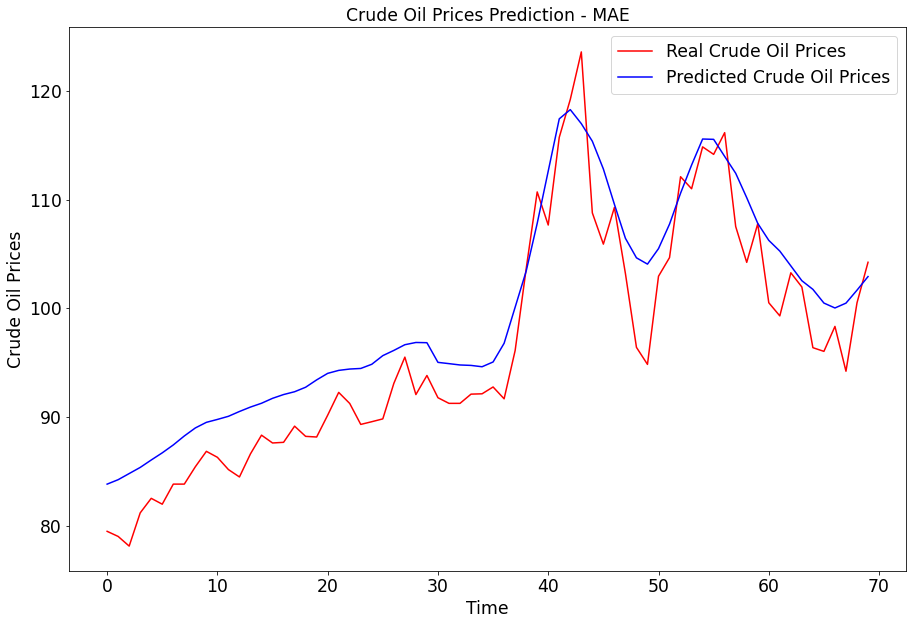

In [30]:
plt.plot(np.float64(test_dataset_v[timestep-3:len(y_test)-3]), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timestep], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()